In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from __future__ import print_function, division


plt.ion() 

In [2]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#install kaggle and create a kaggle folder
!pip install -q kaggle
!mkdir ~/.kaggle

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajkumar123456","key":"dcc7a4cae3a3d77ec1d91b5967c453b8"}'}

In [10]:
#copy the kaggle.json to created folder
! cp kaggle.json ~/.kaggle/

In [11]:
#permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle datasets download grassknoted/asl-alphabet

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [15]:
!pip install split-folders
import splitfolders
input_path = '/content/asl_alphabet_train/asl_alphabet_train'
splitfolders.ratio(input_path, output="output", seed=1337, ratio=(0.80,0.2,0)) 

Copying files: 87000 files [00:15, 5756.51 files/s]


In [16]:
#Augmentation and normalization of data for training
#Normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((120,120)),
        transforms.RandomResizedCrop(120),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.45, 0.46, 0.41], [0.231, 0.226, 0.228])
    ]),
    'val': transforms.Compose([
        transforms.Resize(120),
        transforms.CenterCrop(120),
        transforms.ToTensor(),
        transforms.Normalize([0.45, 0.46, 0.41], [0.231, 0.226, 0.228])
    ]),
}

val_data = '/content/output/val'
train_data = '/content/output/train'
image_datasets = {'train':datasets.ImageFolder(train_data,data_transforms['train']),
                   'val': datasets.ImageFolder(val_data,data_transforms['val'])}
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32,
                                             shuffle=True),
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32,
                                             shuffle=True)}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 69600
    Root location: /content/output/train
    StandardTransform
Transform: Compose(
               Resize(size=(120, 120), interpolation=bilinear, max_size=None, antialias=None)
               RandomResizedCrop(size=(120, 120), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.45, 0.46, 0.41], std=[0.231, 0.226, 0.228])
           )

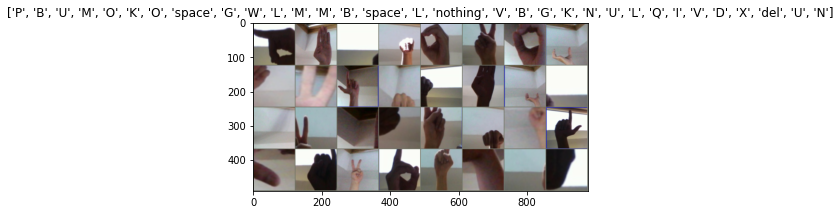

In [18]:
def imshow(inp, title=None):
#imshow for tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.45, 0.46, 0.41])
    std = np.array([0.231, 0.226, 0.228])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
# pause a bit to update plots 


# To Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Making of grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
#ConvNet implementation
class ConvNet(nn.Module): 
  def __init__(self):
    super(ConvNet,self).__init__()
    self.conv1 = nn.Conv2d(3,4,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(4,8,5)
    self.conv3 = nn.Conv2d(8,16,3)
    self.conv4 = nn.Conv2d(16,32,5)
    self.conv5 = nn.Conv2d(32,64,3)
    self.fc1 = nn.Linear(23*23*64,500)
    self.fc2 = nn.Linear(500,250)
    self.fc3 = nn.Linear(250,100)
    self.fc4 = nn.Linear(100,29)
   
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = x.view(-1,23*23*64) 
    # to flatten the image
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x) 
    return x

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
#Declaration of hyperparameter
num_epoch = 10
batch_size = 32
learning_rate = 0.01

In [22]:
#Creating the model with defining of loss function and optimizer
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [23]:
n_total_steps = len(dataloaders['train'])
for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(dataloaders['train']):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epoch}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/10], Step [100/2175], Loss: 3.3705
Epoch [1/10], Step [200/2175], Loss: 3.3668
Epoch [1/10], Step [300/2175], Loss: 3.3580
Epoch [1/10], Step [400/2175], Loss: 3.3718
Epoch [1/10], Step [500/2175], Loss: 3.3665
Epoch [1/10], Step [600/2175], Loss: 3.3491
Epoch [1/10], Step [700/2175], Loss: 3.3652
Epoch [1/10], Step [800/2175], Loss: 3.3619
Epoch [1/10], Step [900/2175], Loss: 3.3613
Epoch [1/10], Step [1000/2175], Loss: 3.3579
Epoch [1/10], Step [1100/2175], Loss: 3.3627
Epoch [1/10], Step [1200/2175], Loss: 3.3691
Epoch [1/10], Step [1300/2175], Loss: 3.3748
Epoch [1/10], Step [1400/2175], Loss: 3.3646
Epoch [1/10], Step [1500/2175], Loss: 3.3610
Epoch [1/10], Step [1600/2175], Loss: 3.3680
Epoch [1/10], Step [1700/2175], Loss: 3.3720
Epoch [1/10], Step [1800/2175], Loss: 3.3641
Epoch [1/10], Step [1900/2175], Loss: 3.3698
Epoch [1/10], Step [2000/2175], Loss: 3.3666
Epoch [1/10], Step [2100/2175], Loss: 3.3689
Epoch [2/10], Step [100/2175], Loss: 3.3686
Epoch [2/10], Step [

In [24]:
correct = 0
total = 0

with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
      
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %') 

Accuracy of the network on the test images: 89 %


In [25]:
classes

tensor([15,  1, 20, 12, 14, 10, 14, 28,  6, 22, 11, 12, 12,  1, 28, 11, 27, 21,
         1,  6, 10, 13, 20, 11, 16,  8, 21,  3, 23, 26, 20, 13])

In [26]:
class_correct = list(1. for i in range(29))
class_total = list(1. for i in range(29))
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [27]:
for i in range(29):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     A : 91 %
Accuracy of     B : 96 %
Accuracy of     C : 98 %
Accuracy of     D : 97 %
Accuracy of     E : 87 %
Accuracy of     F : 87 %
Accuracy of     G : 97 %
Accuracy of     H : 94 %
Accuracy of     I : 96 %
Accuracy of     J : 92 %
Accuracy of     K : 74 %
Accuracy of     L : 95 %
Accuracy of     M : 78 %
Accuracy of     N : 85 %
Accuracy of     O : 96 %
Accuracy of     P : 93 %
Accuracy of     Q : 91 %
Accuracy of     R : 51 %
Accuracy of     S : 87 %
Accuracy of     T : 85 %
Accuracy of     U : 77 %
Accuracy of     V : 85 %
Accuracy of     W : 83 %
Accuracy of     X : 85 %
Accuracy of     Y : 95 %
Accuracy of     Z : 95 %
Accuracy of   del : 98 %
Accuracy of nothing : 96 %
Accuracy of space : 92 %


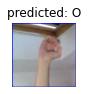

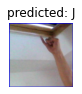

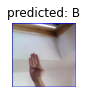

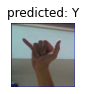

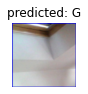

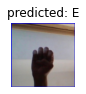

In [28]:
visualize_model(model)